<a href="https://colab.research.google.com/github/RuchiV78/MelanomaDetection/blob/main/RuchiVarma_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin_cancer/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin_cancer/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize one instance of all the nine classes present in the dataset

In [9]:
import matplotlib.pyplot as plt

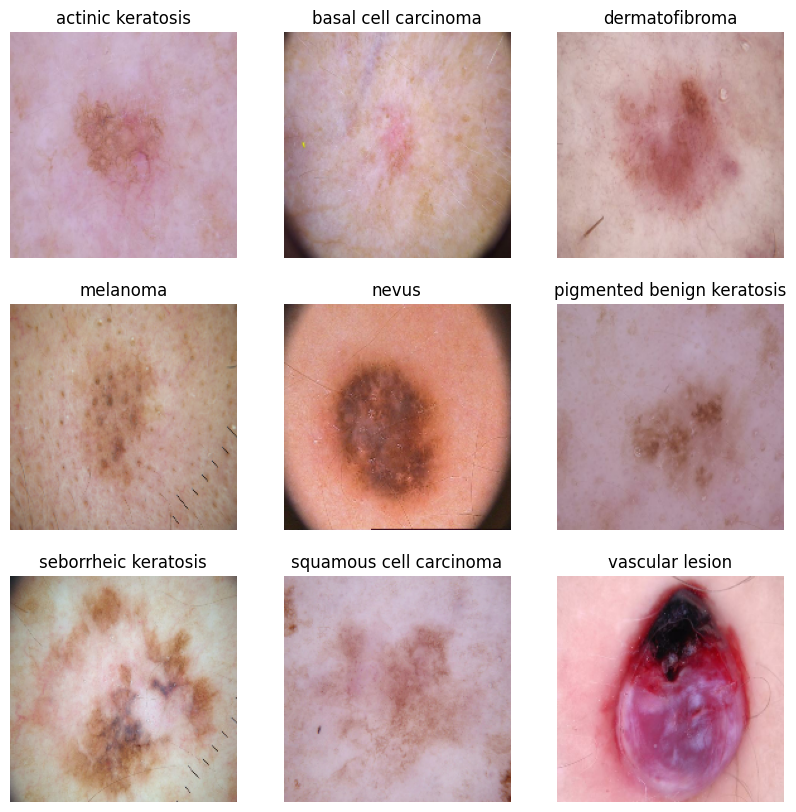

In [10]:
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
   filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))

   for image, label in filtered_ds.take(1):
       ax = plt.subplot(3, 3, i+1)
       plt.imshow(image[0].numpy().astype('uint8'))
       plt.title(class_names[label.numpy()[0]])
       plt.axis('off')


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
#Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 4
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Final Layer
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

**Compile the Model**

In [13]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                        

**Train the Model**

In [15]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 546s 71ms/step - loss: 6.9480 - accuracy: 0.3476 - val_loss: 6.6855 - val_accuracy: 0.0870
Epoch 2/20
169/169 [==============================] - 7s 44ms/step - loss: 4.0245 - accuracy: 0.4585 - val_loss: 5.1793 - val_accuracy: 0.0870
Epoch 3/20
169/169 [==============================] - 7s 43ms/step - loss: 2.6331 - accuracy: 0.5082 - val_loss: 3.3169 - val_accuracy: 0.2174
Epoch 4/20
169/169 [==============================] - 7s 43ms/step - loss: 2.0241 - accuracy: 0.5371 - val_loss: 7.4383 - val_accuracy: 0.1304
Epoch 5/20
169/169 [==============================] - 7s 44ms/step - loss: 1.7473 - accuracy: 0.5690 - val_loss: 6.3598 - val_accuracy: 0.1739
Epoch 6/20
169/169 [==============================] - 7s 43ms/step - loss: 1.6188 - accuracy: 0.5989 - val_loss: 2.6665 - val_accuracy: 0.3043
Epoch 7/20
169/169 [==============================] - 7s 44ms/step - loss: 1.5328 - accuracy: 0.6172 - val_loss: 3.4437 - val_accuracy: 0.1739
Epoch 8/

**Visualizing training results**

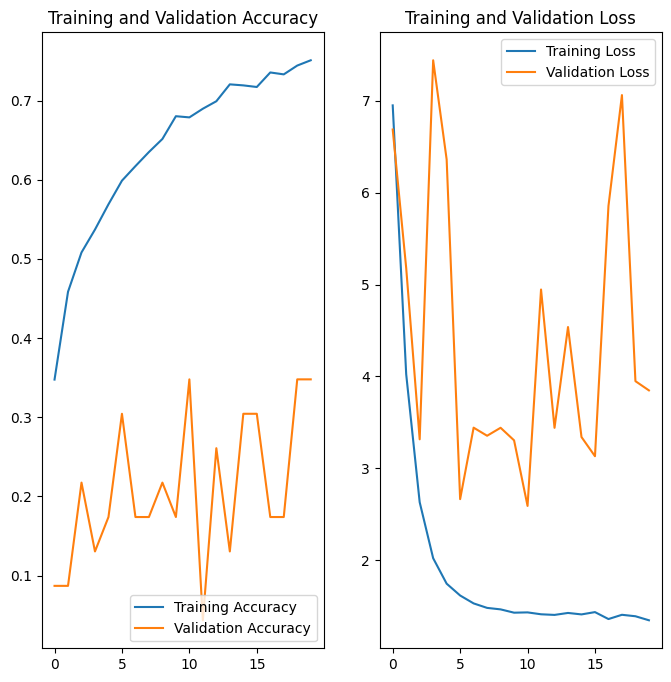

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## **Findings**
It is clearly indicated that the Model is overfitting.. There is a big variation in the Training and Validation Accuracy. Also with the number of iterations of training - the training loss decreases but the same pattern isnt visible in the Validation loss.


## **Data Augmentation**

In [17]:
data_augment = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

**Visualize Augmentation Strategy**

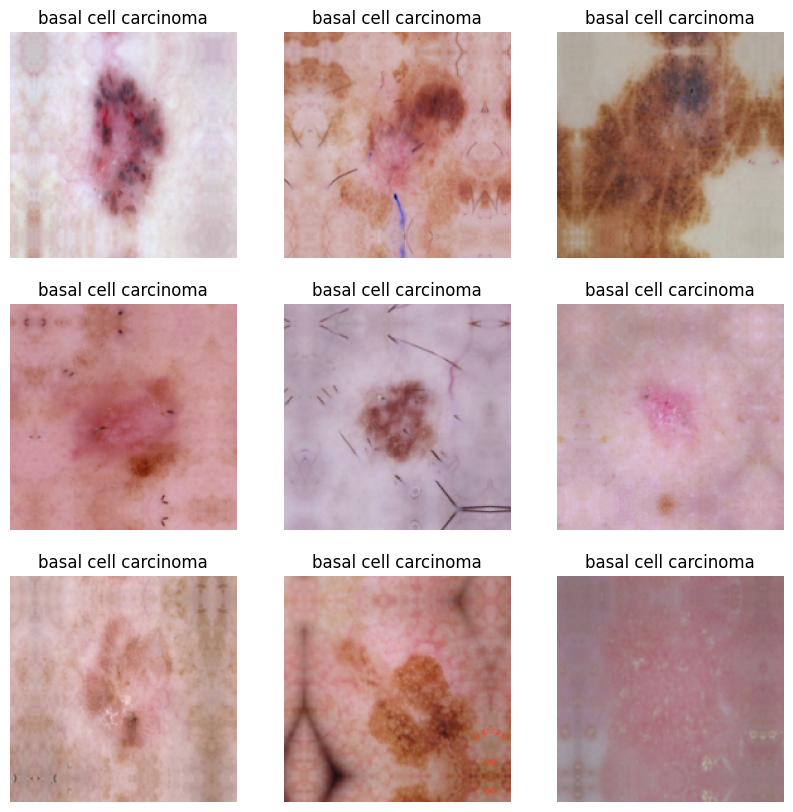

In [18]:
plt.figure(figsize=(10, 10))

for image, label in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augment(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[i].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[1]])
    plt.axis('off')


**Create, Compile and Train the Model**

In [19]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
#Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 4
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Final Layer
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [20]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 activation_6 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_4 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 180, 180, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      25632     
                                                      

In [22]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/20
169/169 [==============================] - 11s 45ms/step - loss: 6.9965 - accuracy: 0.3388 - val_loss: 6.2157 - val_accuracy: 0.0870
Epoch 2/20
169/169 [==============================] - 7s 43ms/step - loss: 4.0824 - accuracy: 0.4622 - val_loss: 4.4969 - val_accuracy: 0.1739
Epoch 3/20
169/169 [==============================] - 7s 44ms/step - loss: 2.6996 - accuracy: 0.5032 - val_loss: 2.9596 - val_accuracy: 0.1739
Epoch 4/20
169/169 [==============================] - 7s 43ms/step - loss: 2.0657 - accuracy: 0.5395 - val_loss: 3.0598 - val_accuracy: 0.2609
Epoch 5/20
169/169 [==============================] - 7s 43ms/step - loss: 1.7359 - accuracy: 0.5859 - val_loss: 2.8656 - val_accuracy: 0.3043
Epoch 6/20
169/169 [==============================] - 7s 43ms/step - loss: 1.5941 - accuracy: 0.6103 - val_loss: 3.1237 - val_accuracy: 0.2174
Epoch 7/20
169/169 [==============================] - 7s 43ms/step - loss: 1.5418 - accuracy: 0.6222 - val_loss: 3.3014 - val_accuracy: 0.260

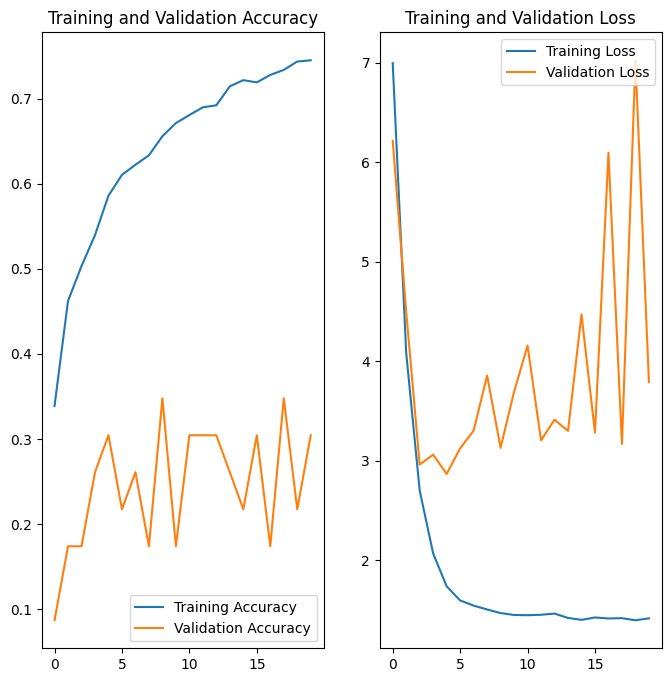

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Performance has fallen. It has worsened. It is still overfitting

**Find the distribution of classes in the training dataset.**

In [24]:
train_ds_unbatched = tuple(train_ds.unbatch())
labels = []

for images, label in train_ds_unbatched:
  labels.append(label.numpy())

labels = pd.Series(labels)

count_class = labels.value_counts().sort_index()
count_class.index = class_names

print(count_class)

actinic keratosis             493
basal cell carcinoma          721
dermatofibroma                455
melanoma                      755
nevus                         677
pigmented benign keratosis    773
seborrheic keratosis          456
squamous cell carcinoma       569
vascular lesion               493
dtype: int64


<Axes: title={'center': 'Class Distribution'}>

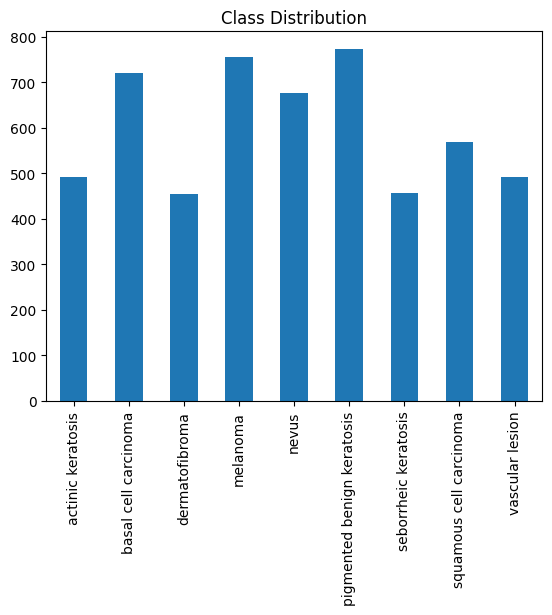

In [25]:
count_class.plot(kind = 'bar', title="Class Distribution")

**Findings**

Dermatofibroma has the least number of samples

Pigmented Benign Keratosis is the most dominant class

**Rectify Class Imbalance**

In [26]:

!pip install Augmentor

In [27]:
path_to_training_dataset= "/content/gdrive/My Drive/Skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787FBE99FC70>: 100%|██████████| 500/500 [00:25<00:00, 19.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x787FA046FCD0>: 100%|██████████| 500/500 [00:27<00:00, 18.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x787FA029AA10>: 100%|██████████| 500/500 [00:23<00:00, 20.98 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x787FA1C69060>: 100%|██████████| 500/500 [01:17<00:00,  6.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787FA23B6320>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787FA03A3EE0>: 100%|██████████| 500/500 [00:18<00:00, 27.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x787FA22E6560>: 100%|██████████| 500/500 [00:38<00:00, 12.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x787FA04F2380>: 100%|██████████| 500/500 [00:22<00:00, 22.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x787FA0298E80>: 100%|██████████| 500/500 [00:18<00:00, 26.99 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [33]:
from glob import glob

In [37]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_0a947464-cd39-45c5-a8bf-ae22da0477c6.jpg',
 '/content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_64e70e31-4eb6-437b-9267-1cf5154c0f77.jpg',
 '/content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026625.jpg_fe2d84fb-ecc5-476e-a4fb-23c01f5bebe5.jpg',
 '/content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_63d959af-9637-4952-9c6d-abfc3b30eaa9.jpg',
 '/content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_1fd512c6-88e4-495a-a8c3-71741ff037bd.jpg',
 '/content/gdrive/My Drive/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_71b79f13-b9fc-42e6-a645-201d60d9dd27.jpg',
 '/content/gdrive/My Drive/Skin_cancer/Train/actinic kerat

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [42]:
new_df['Label'].value_counts()

actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

**Train the model on the data created using Augmentor**

In [43]:
batch_size = 32
img_height = 180
img_width = 180

Create a Training Dataset

In [44]:
##data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin_cancer/Train/")
data_dir_train = path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


Create a Validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


**Model Creation**

In [46]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])
#Layer 1
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1,1) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Layer 4
model.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (2,2) ,padding='same',
                 input_shape= (img_height, img_width, 32)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Final Layer
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

**Compile Model**

In [47]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [48]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 activation_12 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_8 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 180, 180, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      25632     
                                                      

**Train Your Model**

In [49]:
epochs = 30
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 [==============================] - 240s 817ms/step - loss: 5.6177 - accuracy: 0.3862 - val_loss: 4.3374 - val_accuracy: 0.1753
Epoch 2/30
281/281 [==============================] - 59s 206ms/step - loss: 2.4541 - accuracy: 0.5050 - val_loss: 3.5719 - val_accuracy: 0.2483
Epoch 3/30
281/281 [==============================] - 54s 189ms/step - loss: 1.7072 - accuracy: 0.5643 - val_loss: 1.8655 - val_accuracy: 0.5011
Epoch 4/30
281/281 [==============================] - 54s 188ms/step - loss: 1.5615 - accuracy: 0.6014 - val_loss: 1.4922 - val_accuracy: 0.6204
Epoch 5/30
281/281 [==============================] - 56s 195ms/step - loss: 1.5005 - accuracy: 0.6386 - val_loss: 1.6699 - val_accuracy: 0.5839
Epoch 6/30
281/281 [==============================] - 65s 228ms/step - loss: 1.4635 - accuracy: 0.6627 - val_loss: 1.3871 - val_accuracy: 0.6974
Epoch 7/30
281/281 [==============================] - 55s 190ms/step - loss: 1.4599 - accuracy: 0.6774 - val_loss: 2.3815 - val_accuracy: 0.

**Visulaize Model Results**

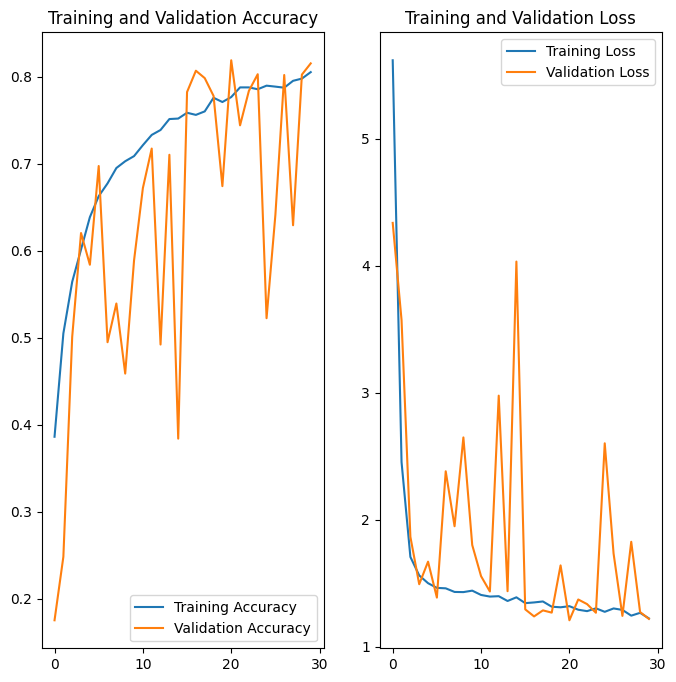

In [50]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analysis** -


*   Using Augmented Data - Accuracy has increased on Training and Validation dataset
*   Training Accuracy - 0.8053 and Validation Accuracy - 0.8153
*   Training Loss - 1.2231 and Validation Loss - 1.2192
*   Class rebalance has really helped the Model
*   Dropouts and Batch Normalization helps in getting Training and Validation Accuracy up.




